# Spin Classification Model

A deep learning model to classify quantum spin configurations

In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

### Loading Datasets

You can load different datasets by changing the dataset path for testing, trainging, and benchmarking

In [43]:
# Set these variables to the appropriate directory paths

test_dir = '../data/8-8/binary_class/test/'
train_dir = '../data/8-8/binary_class/train/'

# Set these variables to the appropriate directory paths
benchmark_dir = '../data/8-8/temp_class/test/'

In [44]:
# data transforms
dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

#create datasets using ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=dset_transform)
test_data = datasets.ImageFolder(test_dir, transform=dset_transform)
benchmark_data = datasets.ImageFolder(benchmark_dir, transform=dset_transform)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

## Architecture

This is the basic architecture of the model. The following parameters can be set:

* `input_size`: The dimensions of the input images. Default: `[25, 25]`
* `hidden_layers`: The number of hidden layers in the model. Default: 5
* `layer_size`: The size of each hidden layer. Default: 128
* `conv`: Boolean to determine if the network should be fully connected or convolutional. Default: False
* `num_classes`: The number of output classes. Leave as 2 for binary classification. Otherwise set to number of temperature values for which data is available. Default: 2


In [45]:
input_size = [8,8]
hidden_layers = 4
layer_size = 128
conv = True # True for convolutional, False for fully connected
num_classes = 2

In [46]:
def linear_block(layer_size, num_layers):
    layers = []
    for i in range(num_layers):
        layers.append(nn.Linear(layer_size, layer_size))
        layers.append(nn.ReLU())
    return layers
    

In [47]:
def conv_block(layer_size, num_layers):
    layers = []
    for i in range(num_layers):
        layers.append(nn.Conv2d(layer_size, layer_size, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm2d(layer_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
    return layers

In [48]:
class SpinClassifier(nn.Module): 
    def __init__(self, input_size, hidden_layers, layer_size, num_classes, conv):
        super(SpinClassifier, self).__init__()
        self.conv = conv
        self.input_size = input_size
        self.input_dim = np.prod(input_size)
        self.output_dim = num_classes
        self.num_layers = hidden_layers
        self.layer_size = layer_size
        
        if self.conv:
            self.input_layer = [nn.Conv2d(1, self.layer_size, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)]
            self.output_layer = [nn.Conv2d(self.layer_size, self.output_dim, kernel_size=3, stride=1, padding=1), 
                                 nn.ReLU(), 
                                 nn.MaxPool2d(kernel_size=2, stride=2), 
                                 nn.Flatten(),
                                 nn.Linear(self.output_dim*6*6, self.output_dim)]
            self.layers = conv_block(self.layer_size, self.num_layers)
        else:
            self.input_layer = [nn.Linear(self.input_dim, self.layer_size), nn.ReLU()]
            self.output_layer = [nn.Linear(self.layer_size, self.output_dim)]
            self.layers = linear_block(self.layer_size, self.num_layers)
        
        self.model = nn.Sequential(*self.input_layer, *self.layers, *self.output_layer)


        
    def forward(self, x):
        if not self.conv:
            x = x.view(-1, self.input_dim)
        x = self.model(x)
        return x
        

Now we can set up the model and the training

In [49]:
DEVICE = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [50]:
model = SpinClassifier(input_size, hidden_layers, layer_size, num_classes, conv).to(DEVICE)

max_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

save_path = './models/Spin_Classifier.pt'
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

### Training the model

In [51]:
train_loss_history = []
test_loss_history = []

for epoch in range(max_epochs):

    train_loss = 0.0
    test_loss = 0.0

    for i, data in enumerate(train_loader):

        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        predicted_output = model(images)
        fit = criterion(predicted_output, labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item() / len(train_data)

    for i, data in enumerate(test_loader):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        predicted_output = model(images)
        fit = criterion(predicted_output, labels)
        test_loss += fit.item() / len(test_data)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

    print(f'Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 72x2)

Now we can plot our loss to see how the model improved over time

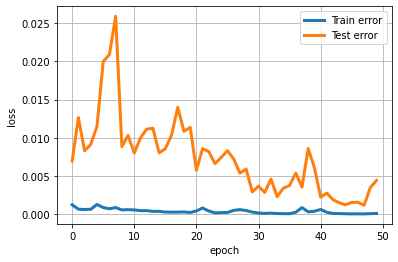

In [ ]:
plt.plot(range(max_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(max_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

## Plotting our Results

/tmp/ipykernel_1115966/765349691.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()


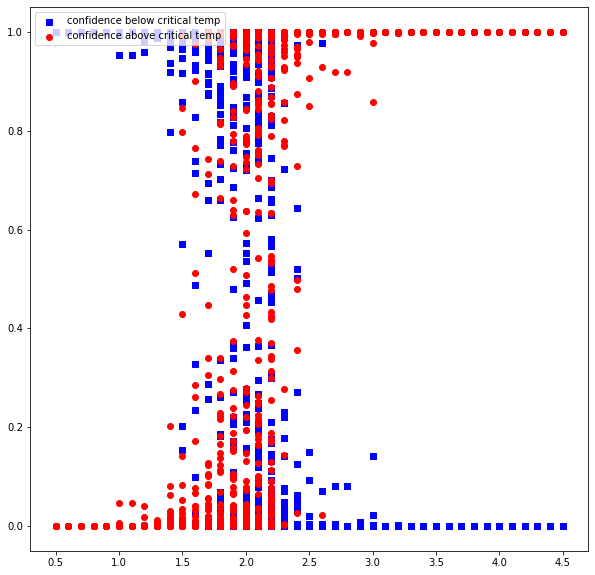

In [ ]:
temp_pred_below = []
temp_pred_above = []
for idx in range(len(benchmark_data)):
  image, label = benchmark_data[idx]
  predicted_output = model(image.unsqueeze(0))
  
  # Need to apply softmax to get probabilities
  prob_output = torch.nn.functional.softmax(predicted_output).detach().numpy()
  predicted_label = torch.argmax(predicted_output).item()
  # print(f"predicted label: {predicted_label}, actual label: {label}")

  #get temp from label
  temp = benchmark_data.classes[label]
  temp_pred_below.append([float(temp), prob_output[0][1]])
  temp_pred_above.append([float(temp), prob_output[0][0]])

#plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter([x[0] for x in temp_pred_below], [x[1] for x in temp_pred_below], c='b', marker="s", label='confidence below critical temp')
ax.scatter([x[0] for x in temp_pred_above], [x[1] for x in temp_pred_above], c='r', marker="o", label='confidence above critical temp')

plt.legend(loc='upper left');
plt.show()


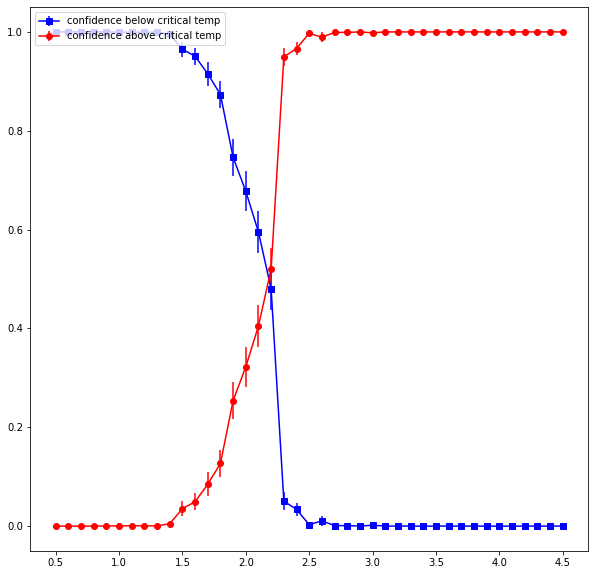

In [ ]:
#plot the average confidence for each temperature with error bars
#error bars are standard deviation devide by sqrt of number of samples

# get the average & standard deviation of confidence for each temperature
temp_pred_below_avg = {}
temp_pred_above_avg = {}

temp_pred_below_std = {}
temp_pred_above_std = {}

for temp, pred in temp_pred_below:
    if temp in temp_pred_below_avg:
        temp_pred_below_avg[temp].append(pred)
    else:
        temp_pred_below_avg[temp] = [pred]

    if temp in temp_pred_below_std:
        temp_pred_below_std[temp].append(pred)
    else:
        temp_pred_below_std[temp] = [pred]

for temp, pred in temp_pred_above:
    if temp in temp_pred_above_avg:
        temp_pred_above_avg[temp].append(pred)
    else:
        temp_pred_above_avg[temp] = [pred]

    if temp in temp_pred_above_std:
        temp_pred_above_std[temp].append(pred)
    else:
        temp_pred_above_std[temp] = [pred]

temp_pred_above_avg = {temp: np.mean(pred) for temp, pred in temp_pred_above_avg.items()}
temp_pred_below_avg = {temp: np.mean(pred) for temp, pred in temp_pred_below_avg.items()}

temp_pred_above_err = {temp: np.std(pred)/np.sqrt(len(pred)) for temp, pred in temp_pred_above_std.items()}
temp_pred_below_err = {temp: np.std(pred)/np.sqrt(len(pred)) for temp, pred in temp_pred_below_std.items()}

    
#plot the data
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.errorbar(list(temp_pred_below_avg.keys()), list(temp_pred_below_avg.values()), yerr=list(temp_pred_below_err.values()), c='b', marker="s", label='confidence below critical temp')
ax.errorbar(list(temp_pred_above_avg.keys()), list(temp_pred_above_avg.values()), yerr=list(temp_pred_above_err.values()), c='r', marker="o", label='confidence above critical temp')

plt.legend(loc='upper left');
plt.show()
    

### Save the model

In [ ]:
torch.save(model.state_dict(), './models/8-8/Conv_NN.pth')